Цыварев Илья, вариант 1
Метод активации -  Tanh
Шаг градиентного спуска - 0.001

Задание 1

Свертка - операция, которая лежит в основе реализации сверточных сетей. Неформально эту операцию можно описать следующим образом — окном размера ядра g проходим с заданным шагом (обычно 1) все изображение f, на каждом шаге поэлементно умножаем содержимое окна на ядро g, результат суммируется и записывается в матрицу результата

Паддинг - добавляет к краям изображения поддельные пиксели. Таким образом, ядро при проскальзывании позволяет неподдельным пикселям оказываться в своем центре, а затем распространяется на поддельные пиксели за пределами края, создавая выходную матрицу того же размера, что и входная.

Страйд - идея страйда заключается в том, чтобы пропустить некоторые области, над которыми скользит ядро. Шаг 1 означает, что берутся пролеты через пиксель, то есть по факту каждый пролет является стандартной сверткой. Шаг 2 означает, что пролеты совершаются через каждые два пикселя, пропуская все другие пролеты в процессе и уменьшая их количество примерно в 2 раза, шаг 3 означает пропуск 3-х пикселей, сокращая количество в 3 раза и т.д.

average_pooling, max_pooling - пулинговый слой призван снижать размерность изображения. Исходное изображение делится на блоки размером w×h и для каждого блока вычисляется некоторая функция. Чаще всего используется функция максимума (max pooling) или (взвешенного) среднего (average pooling)

In [1]:
import torch
import random
import numpy as np
import pandas as pd

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
len(y_train), len(y_test)

(60000, 10000)

In [6]:
X_train = X_train.float()
X_test = X_test.float()

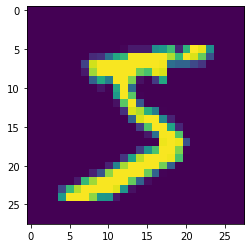

tensor(5)


In [7]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [8]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [9]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [10]:
class LeNet5(torch.nn.Module):
    def __init__(self, n_layers = 1, activation = 'tanh', pooling = 'average'):
        super(LeNet5, self).__init__()
        
        if activation == 'tanh':
            act = torch.nn.Tanh()
        elif activation == 'relu':
            act = torch.nn.ReLU()
            
        if pooling == 'average':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        feature_extractor = torch.nn.Sequential()
        
        feature_extractor.add_module('conv_input',torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
        feature_extractor.add_module('activation_input',act)
        feature_extractor.add_module('pooling1',pooling_layer)
        for i in range(n_layers):
            feature_extractor.add_module(f'conv_{i}',torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=5, padding=2))
            feature_extractor.add_module(f'activation_{i}',act)
            
        feature_extractor.add_module('conv_last',torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0))
        feature_extractor.add_module('activation_last',act)
        feature_extractor.add_module('pooling2',pooling_layer)
        
        classifier = torch.nn.Sequential()
        
        classifier.add_module('linear1',torch.nn.Linear(5 * 5 * 16, 120))
        classifier.add_module('activation3',act)
        classifier.add_module('linear2',torch.nn.Linear(120, 84))
        classifier.add_module('activation4',act)
        classifier.add_module('linear3',torch.nn.Linear(84, 10))
        
        self.feature_extractor = feature_extractor
        self.classifier = classifier
    
    def forward(self, x):
        
        x = self.feature_extractor(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.classifier(x)
        
        return x

In [11]:
def train(net,optimizer,X_train,y_train,X_test,y_test, device, batch_size = 10240,n_epochs = 1000):
    loss = torch.nn.CrossEntropyLoss()
    test_accuracy_history = []
    test_loss_history = []
    train_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)
    for epoch in range(n_epochs):
        order = np.random.permutation(len(X_train))
        n_true_preds = 0
        n_total = 0
        train_step_loss_history = []
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch) 
            n_true_preds += (preds.argmax(dim=1) == y_batch).float().sum().item()
            n_total += len(preds)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            train_step_loss_history.append(loss_value.item())

        train_loss_history.append(torch.mean(torch.Tensor(train_step_loss_history)).item())
        with torch.no_grad():
          test_preds = net.forward(X_test)
          test_loss_history.append(loss(test_preds, y_test).cpu().item())

          accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
          test_accuracy_history.append(accuracy)
        print(f'Epoch : {epoch}, accuracy: {accuracy}')
        
    print(f'Max test accuracy : {max(test_accuracy_history)}')
    pd.DataFrame({'train': train_loss_history, 'test': test_loss_history}).plot()

Задание 2

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = LeNet5().to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)

Epoch : 0, accuracy: 0.5455999970436096
Epoch : 1, accuracy: 0.5925999879837036
Epoch : 2, accuracy: 0.6832999587059021
Epoch : 3, accuracy: 0.7829999923706055
Epoch : 4, accuracy: 0.8378999829292297
Epoch : 5, accuracy: 0.8643999695777893
Epoch : 6, accuracy: 0.8794999718666077
Epoch : 7, accuracy: 0.8933999538421631
Epoch : 8, accuracy: 0.9012999534606934
Epoch : 9, accuracy: 0.9104999899864197
Epoch : 10, accuracy: 0.9195999503135681
Epoch : 11, accuracy: 0.927299976348877
Epoch : 12, accuracy: 0.9335999488830566
Epoch : 13, accuracy: 0.9398999810218811
Epoch : 14, accuracy: 0.9451999664306641
Epoch : 15, accuracy: 0.9488999843597412
Epoch : 16, accuracy: 0.9524999856948853
Epoch : 17, accuracy: 0.9562999606132507
Epoch : 18, accuracy: 0.958899974822998
Epoch : 19, accuracy: 0.9614999890327454
Max test accuracy : 0.9614999890327454


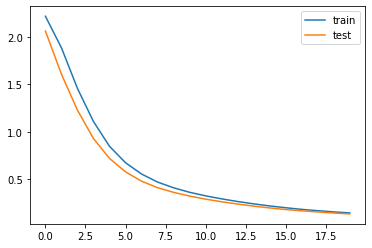

In [13]:
train(lenet5,optimizer, 
    X_train,y_train,
    X_test,y_test, 
    device, 
    batch_size = 10240,
    n_epochs = 20)

Задание 3

Epoch : 0, accuracy: 0.5227000117301941
Epoch : 1, accuracy: 0.5866999626159668
Epoch : 2, accuracy: 0.7002999782562256
Epoch : 3, accuracy: 0.7563999891281128
Epoch : 4, accuracy: 0.8069999814033508
Epoch : 5, accuracy: 0.842799961566925
Epoch : 6, accuracy: 0.8637999892234802
Epoch : 7, accuracy: 0.8815999627113342
Epoch : 8, accuracy: 0.8969999551773071
Epoch : 9, accuracy: 0.9056999683380127
Epoch : 10, accuracy: 0.9156000018119812
Epoch : 11, accuracy: 0.9211999773979187
Epoch : 12, accuracy: 0.9286999702453613
Epoch : 13, accuracy: 0.9343999624252319
Epoch : 14, accuracy: 0.9396999478340149
Epoch : 15, accuracy: 0.9435999989509583
Epoch : 16, accuracy: 0.9467999935150146
Epoch : 17, accuracy: 0.9508999586105347
Epoch : 18, accuracy: 0.9527999758720398
Epoch : 19, accuracy: 0.9569000005722046
Max test accuracy : 0.9569000005722046


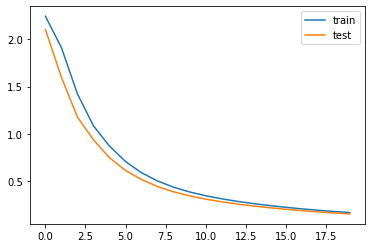

In [16]:
lenet5 = LeNet5(2,'tanh').to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 20)

Epoch : 0, accuracy: 0.5455999970436096
Epoch : 1, accuracy: 0.7185999751091003
Epoch : 2, accuracy: 0.7824999690055847
Epoch : 3, accuracy: 0.8596000075340271
Epoch : 4, accuracy: 0.8822000026702881
Epoch : 5, accuracy: 0.8949999809265137
Epoch : 6, accuracy: 0.9120000004768372
Epoch : 7, accuracy: 0.9246000051498413
Epoch : 8, accuracy: 0.9343000054359436
Epoch : 9, accuracy: 0.9424999952316284
Epoch : 10, accuracy: 0.948699951171875
Epoch : 11, accuracy: 0.9541999697685242
Epoch : 12, accuracy: 0.9587000012397766
Epoch : 13, accuracy: 0.9631999731063843
Epoch : 14, accuracy: 0.965499997138977
Epoch : 15, accuracy: 0.9687999486923218
Epoch : 16, accuracy: 0.9708999991416931
Epoch : 17, accuracy: 0.9711999893188477
Epoch : 18, accuracy: 0.9736999869346619
Epoch : 19, accuracy: 0.9752999544143677
Max test accuracy : 0.9752999544143677


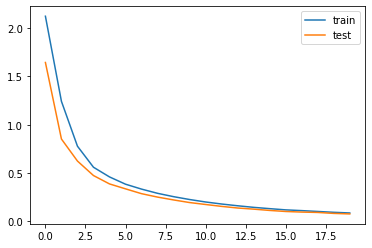

In [18]:
lenet5 = LeNet5(2,'relu').to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 20)

Изменение типа активации увеличило максимальную точность на 2%

Epoch : 0, accuracy: 0.4034999907016754
Epoch : 1, accuracy: 0.5306000113487244
Epoch : 2, accuracy: 0.6484999656677246
Epoch : 3, accuracy: 0.7387999892234802
Epoch : 4, accuracy: 0.7821999788284302
Epoch : 5, accuracy: 0.821399986743927
Epoch : 6, accuracy: 0.8518999814987183
Epoch : 7, accuracy: 0.8792999982833862
Epoch : 8, accuracy: 0.9003999829292297
Epoch : 9, accuracy: 0.9174000024795532
Epoch : 10, accuracy: 0.9265999794006348
Epoch : 11, accuracy: 0.9332000017166138
Epoch : 12, accuracy: 0.9389999508857727
Epoch : 13, accuracy: 0.9437999725341797
Epoch : 14, accuracy: 0.9495999813079834
Epoch : 15, accuracy: 0.9528999924659729
Epoch : 16, accuracy: 0.9566999673843384
Epoch : 17, accuracy: 0.9601999521255493
Epoch : 18, accuracy: 0.9620999693870544
Epoch : 19, accuracy: 0.9635999798774719
Epoch : 20, accuracy: 0.9639999866485596
Epoch : 21, accuracy: 0.9666999578475952
Epoch : 22, accuracy: 0.9662999510765076
Epoch : 23, accuracy: 0.9687999486923218
Epoch : 24, accuracy: 0.970

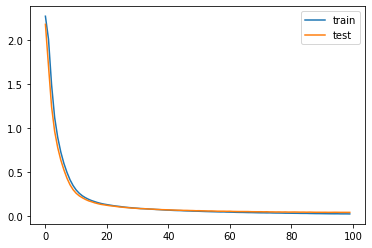

In [19]:
lenet5 = LeNet5(3).to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 100)

Epoch : 0, accuracy: 0.1832999885082245
Epoch : 1, accuracy: 0.4722999930381775
Epoch : 2, accuracy: 0.5633000135421753
Epoch : 3, accuracy: 0.6951999664306641
Epoch : 4, accuracy: 0.7651999592781067
Epoch : 5, accuracy: 0.8095999956130981
Epoch : 6, accuracy: 0.8337999582290649
Epoch : 7, accuracy: 0.8527999520301819
Epoch : 8, accuracy: 0.8707000017166138
Epoch : 9, accuracy: 0.8876999616622925
Epoch : 10, accuracy: 0.9014999866485596
Epoch : 11, accuracy: 0.9143999814987183
Epoch : 12, accuracy: 0.9261999726295471
Epoch : 13, accuracy: 0.9352999925613403
Epoch : 14, accuracy: 0.9431999921798706
Epoch : 15, accuracy: 0.9495999813079834
Epoch : 16, accuracy: 0.9537999629974365
Epoch : 17, accuracy: 0.9580000042915344
Epoch : 18, accuracy: 0.9607999920845032
Epoch : 19, accuracy: 0.9631999731063843
Epoch : 20, accuracy: 0.9648000001907349
Epoch : 21, accuracy: 0.9682999849319458
Epoch : 22, accuracy: 0.9695999622344971
Epoch : 23, accuracy: 0.9702000021934509
Epoch : 24, accuracy: 0.97

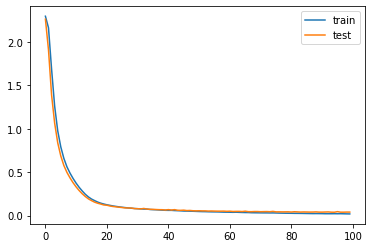

In [20]:
lenet5 = LeNet5(5).to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 100)

Epoch : 0, accuracy: 0.17009998857975006
Epoch : 1, accuracy: 0.33249998092651367
Epoch : 2, accuracy: 0.4219000041484833
Epoch : 3, accuracy: 0.5388999581336975
Epoch : 4, accuracy: 0.5776000022888184
Epoch : 5, accuracy: 0.6559000015258789
Epoch : 6, accuracy: 0.7098999619483948
Epoch : 7, accuracy: 0.7673999667167664
Epoch : 8, accuracy: 0.8100999593734741
Epoch : 9, accuracy: 0.8446999788284302
Epoch : 10, accuracy: 0.8691999912261963
Epoch : 11, accuracy: 0.8906999826431274
Epoch : 12, accuracy: 0.9067999720573425
Epoch : 13, accuracy: 0.9186999797821045
Epoch : 14, accuracy: 0.9283999800682068
Epoch : 15, accuracy: 0.9352999925613403
Epoch : 16, accuracy: 0.9438999891281128
Epoch : 17, accuracy: 0.9531999826431274
Epoch : 18, accuracy: 0.9558999538421631
Epoch : 19, accuracy: 0.9578999876976013
Epoch : 20, accuracy: 0.9602999687194824
Epoch : 21, accuracy: 0.9641000032424927
Epoch : 22, accuracy: 0.9652999639511108
Epoch : 23, accuracy: 0.9666000008583069
Epoch : 24, accuracy: 0.

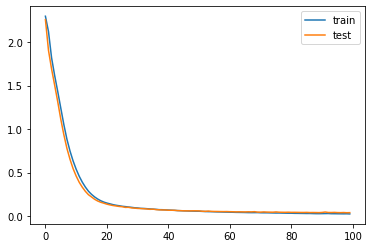

In [21]:
lenet5 = LeNet5(7).to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 100)

Изменение количества слоёв не дало результата в увеличении точности

Epoch : 0, accuracy: 0.541700005531311
Epoch : 1, accuracy: 0.5509999990463257
Epoch : 2, accuracy: 0.6383000016212463
Epoch : 3, accuracy: 0.7756999731063843
Epoch : 4, accuracy: 0.8463000059127808
Epoch : 5, accuracy: 0.8892999887466431
Epoch : 6, accuracy: 0.9053999781608582
Epoch : 7, accuracy: 0.918999969959259
Epoch : 8, accuracy: 0.9267999529838562
Epoch : 9, accuracy: 0.936199963092804
Epoch : 10, accuracy: 0.9426999688148499
Epoch : 11, accuracy: 0.9483999609947205
Epoch : 12, accuracy: 0.9519000053405762
Epoch : 13, accuracy: 0.9547999501228333
Epoch : 14, accuracy: 0.9587000012397766
Epoch : 15, accuracy: 0.961899995803833
Epoch : 16, accuracy: 0.9645999670028687
Epoch : 17, accuracy: 0.9651999473571777
Epoch : 18, accuracy: 0.9663999676704407
Epoch : 19, accuracy: 0.9684999585151672
Max test accuracy : 0.9684999585151672


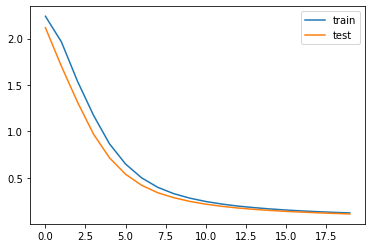

In [22]:
lenet5 = LeNet5().to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 20)

Epoch : 0, accuracy: 0.7918999791145325
Epoch : 1, accuracy: 0.8940999507904053
Epoch : 2, accuracy: 0.9382999539375305
Epoch : 3, accuracy: 0.9562000036239624
Epoch : 4, accuracy: 0.9646999835968018
Epoch : 5, accuracy: 0.9710999727249146
Epoch : 6, accuracy: 0.97489994764328
Epoch : 7, accuracy: 0.977400004863739
Epoch : 8, accuracy: 0.9803999662399292
Epoch : 9, accuracy: 0.9815999865531921
Epoch : 10, accuracy: 0.9835000038146973
Epoch : 11, accuracy: 0.9838999509811401
Epoch : 12, accuracy: 0.983299970626831
Epoch : 13, accuracy: 0.9850999712944031
Epoch : 14, accuracy: 0.9839999675750732
Epoch : 15, accuracy: 0.98499995470047
Epoch : 16, accuracy: 0.9861999750137329
Epoch : 17, accuracy: 0.986299991607666
Epoch : 18, accuracy: 0.9855999946594238
Epoch : 19, accuracy: 0.9871999621391296
Max test accuracy : 0.9871999621391296


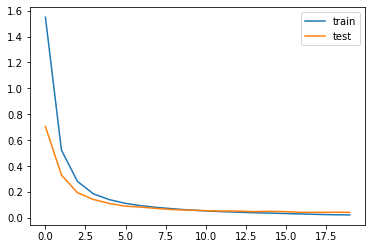

In [23]:
lenet5 = LeNet5().to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.01)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 20)

Изменение шага lr в 10 раз дало увеличение точности на 2%

Epoch : 0, accuracy: 0.5877999663352966
Epoch : 1, accuracy: 0.564300000667572
Epoch : 2, accuracy: 0.6626999974250793
Epoch : 3, accuracy: 0.7116000056266785
Epoch : 4, accuracy: 0.7804999947547913
Epoch : 5, accuracy: 0.8113999962806702
Epoch : 6, accuracy: 0.8399999737739563
Epoch : 7, accuracy: 0.8676999807357788
Epoch : 8, accuracy: 0.8872999548912048
Epoch : 9, accuracy: 0.9039999842643738
Epoch : 10, accuracy: 0.9156999588012695
Epoch : 11, accuracy: 0.9243999719619751
Epoch : 12, accuracy: 0.935699999332428
Epoch : 13, accuracy: 0.9405999779701233
Epoch : 14, accuracy: 0.9459999799728394
Epoch : 15, accuracy: 0.9497999548912048
Epoch : 16, accuracy: 0.9539999961853027
Epoch : 17, accuracy: 0.9580000042915344
Epoch : 18, accuracy: 0.9601999521255493
Epoch : 19, accuracy: 0.9633999466896057
Max test accuracy : 0.9633999466896057


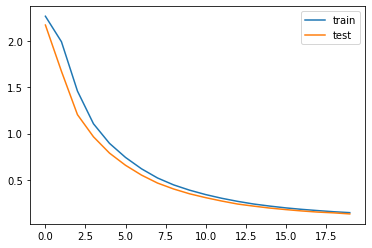

In [27]:
lenet5 = LeNet5(3,'tanh', 'average').to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 20)

Epoch : 0, accuracy: 0.5408999919891357
Epoch : 1, accuracy: 0.555400013923645
Epoch : 2, accuracy: 0.6688999533653259
Epoch : 3, accuracy: 0.7597000002861023
Epoch : 4, accuracy: 0.8047999739646912
Epoch : 5, accuracy: 0.839199960231781
Epoch : 6, accuracy: 0.8685999512672424
Epoch : 7, accuracy: 0.890999972820282
Epoch : 8, accuracy: 0.9048999547958374
Epoch : 9, accuracy: 0.9147999882698059
Epoch : 10, accuracy: 0.9239999651908875
Epoch : 11, accuracy: 0.9328999519348145
Epoch : 12, accuracy: 0.9404999613761902
Epoch : 13, accuracy: 0.9472999572753906
Epoch : 14, accuracy: 0.9519999623298645
Epoch : 15, accuracy: 0.9546999931335449
Epoch : 16, accuracy: 0.9580999612808228
Epoch : 17, accuracy: 0.9594999551773071
Epoch : 18, accuracy: 0.9620999693870544
Epoch : 19, accuracy: 0.9626999497413635
Max test accuracy : 0.9626999497413635


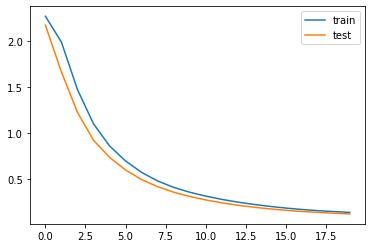

In [28]:
lenet5 = LeNet5(3,'tanh', 'max').to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 20)

Разница между типами пулинга не дала заметного прироста точности

Задание 4

Epoch : 0, accuracy: 0.9035999774932861
Epoch : 1, accuracy: 0.9473999738693237
Epoch : 2, accuracy: 0.965999960899353
Epoch : 3, accuracy: 0.9729999899864197
Epoch : 4, accuracy: 0.975600004196167
Epoch : 5, accuracy: 0.9797999858856201
Epoch : 6, accuracy: 0.9805999994277954
Epoch : 7, accuracy: 0.9821999669075012
Epoch : 8, accuracy: 0.9837999939918518
Epoch : 9, accuracy: 0.9847999811172485
Epoch : 10, accuracy: 0.9856999516487122
Epoch : 11, accuracy: 0.9854999780654907
Epoch : 12, accuracy: 0.9857999682426453
Epoch : 13, accuracy: 0.9874999523162842
Epoch : 14, accuracy: 0.9869999885559082
Epoch : 15, accuracy: 0.9865999817848206
Epoch : 16, accuracy: 0.9866999983787537
Epoch : 17, accuracy: 0.9873999953269958
Epoch : 18, accuracy: 0.9868999719619751
Epoch : 19, accuracy: 0.9874999523162842
Max test accuracy : 0.9874999523162842
Epoch : 0, accuracy: 0.8981000185012817
Epoch : 1, accuracy: 0.949999988079071
Epoch : 2, accuracy: 0.9682000279426575
Epoch : 3, accuracy: 0.97509998083

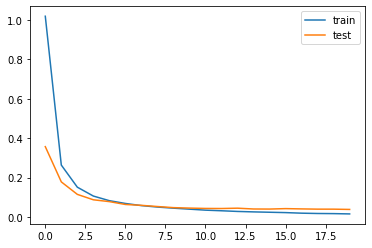

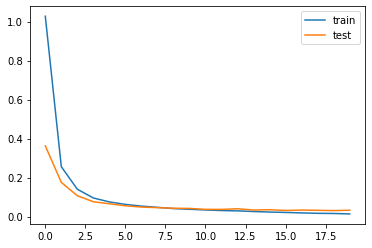

In [34]:
from time import time
lenet5 = LeNet5().to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)
start_gpu = time()

train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 1024,
        n_epochs = 20)
finish_gpu = time()

lenet5 = LeNet5().to('cpu')
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)

start_cpu = time()
train(lenet5,optimizer,
      X_train.cpu(),y_train.cpu(),
      X_test.cpu(),y_test.cpu(), 
      'cpu', 
      batch_size = 1024,
      n_epochs = 20)

finish_cpu = time()

print(f'gpu training takes {finish_gpu - start_gpu}')
print(f'cpu training takes {finish_cpu - start_cpu}')

Время тренировки на GPU в 12 раз меньше времени тренировки на CPU

Задание 5

Epoch : 0, accuracy: 0.6916999816894531
Epoch : 1, accuracy: 0.6650999784469604
Epoch : 2, accuracy: 0.7085999846458435
Epoch : 3, accuracy: 0.7803999781608582
Epoch : 4, accuracy: 0.849399983882904
Epoch : 5, accuracy: 0.873199999332428
Epoch : 6, accuracy: 0.8892999887466431
Epoch : 7, accuracy: 0.9006999731063843
Epoch : 8, accuracy: 0.9091999530792236
Epoch : 9, accuracy: 0.918999969959259
Epoch : 10, accuracy: 0.9249999523162842
Epoch : 11, accuracy: 0.9309999942779541
Epoch : 12, accuracy: 0.9348999857902527
Epoch : 13, accuracy: 0.9404999613761902
Epoch : 14, accuracy: 0.9458999633789062
Epoch : 15, accuracy: 0.9495999813079834
Epoch : 16, accuracy: 0.9541999697685242
Epoch : 17, accuracy: 0.9577999711036682
Epoch : 18, accuracy: 0.9602999687194824
Epoch : 19, accuracy: 0.9645999670028687
Epoch : 20, accuracy: 0.9666999578475952
Epoch : 21, accuracy: 0.967799961566925
Epoch : 22, accuracy: 0.9696999788284302
Epoch : 23, accuracy: 0.9710999727249146
Epoch : 24, accuracy: 0.972599

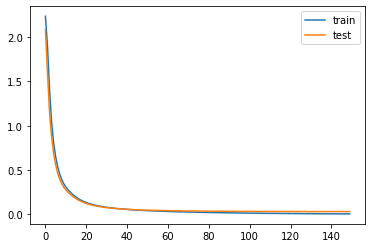

In [36]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = LeNet5().to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)

train(lenet5,optimizer, 
    X_train,y_train,
    X_test,y_test, 
    device, 
    batch_size = 10240,
    n_epochs = 150)

Задание 6

Epoch : 0, accuracy: 0.5708999633789062
Epoch : 1, accuracy: 0.560699999332428
Epoch : 2, accuracy: 0.6870999932289124
Epoch : 3, accuracy: 0.7878999710083008
Epoch : 4, accuracy: 0.8205999732017517
Epoch : 5, accuracy: 0.850600004196167
Epoch : 6, accuracy: 0.8772000074386597
Epoch : 7, accuracy: 0.8988999724388123
Epoch : 8, accuracy: 0.9154999852180481
Epoch : 9, accuracy: 0.9268999695777893
Epoch : 10, accuracy: 0.9351999759674072
Epoch : 11, accuracy: 0.9417999982833862
Epoch : 12, accuracy: 0.9466999769210815
Epoch : 13, accuracy: 0.9528999924659729
Epoch : 14, accuracy: 0.957099974155426
Epoch : 15, accuracy: 0.9602999687194824
Epoch : 16, accuracy: 0.9625999927520752
Epoch : 17, accuracy: 0.9645999670028687
Epoch : 18, accuracy: 0.9662999510765076
Epoch : 19, accuracy: 0.9682999849319458
Epoch : 20, accuracy: 0.9699999690055847
Epoch : 21, accuracy: 0.9715999960899353
Epoch : 22, accuracy: 0.9724999666213989
Epoch : 23, accuracy: 0.9735999703407288
Epoch : 24, accuracy: 0.97479

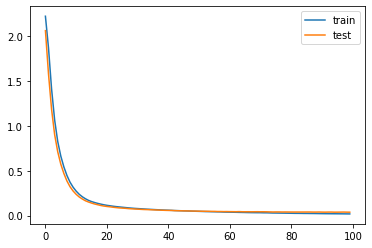

In [40]:
lenet5 = LeNet5().to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)
start_gpu = time()

train(lenet5,optimizer,
    X_train,y_train,
    X_test,y_test, 
    device, 
    batch_size = 10240,
    n_epochs = 100)

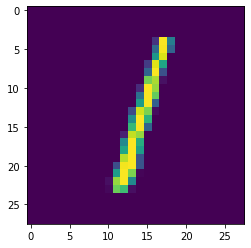

tensor(1)


In [41]:
plt.imshow(X_test[2][0].cpu())
plt.show()
print(y_test[2])

In [43]:
lenet5.forward(X_test[2].unsqueeze(0).cuda()).argmax(1).item()

1

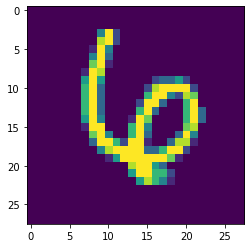

tensor(6)


6

In [44]:
plt.imshow(X_test[22][0].cpu())
plt.show()
print(y_test[22])

lenet5.forward(X_test[22].unsqueeze(0).cuda()).argmax(1).item()

Созданная сеть успешно справляется с распознаванием изображений